In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kruskal
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Set main directory
os.chdir('/Users/giandomenico/Documents/SAPIENZA/AR/MiC')
# set plotting settings
sns.set_theme(context='paper', style="whitegrid", palette="husl", font='arial', font_scale=1.2)

plt.rcParams.update({
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11
    })


In [3]:
# Load datasets
filepath = 'Rieti/Buildings/centroidi_edifici_CH_DISP_GEO_MS.shp'
data = gpd.read_file(filepath)

# cleaning based on VEL_ASC and UD_CUM coherency
data = data.drop(data[data.VEL_ASC == 0].index)

data['COD_gt'] = data['COD'].replace(['01','05','07','08'], [1,5,7,8])
data['Lithology'] = data['COD'].replace(['01','05','07','08'],
                                        ['Backfill', 'Sand-Silt', 'Travertine (detritic)', 'Travertine (lithoid)'])

data.head()

,Join_Count,TARGET_FID,FID_Edific,DENOMINAZI,LOCALIZZAZ,CATEGORIA,TIPOLOGIA,MATERIALE,DATAZIONE,Note_MS,UD_CUM,VEL_ASC,Tipo_gt,COD,NOTE_GEO,geometry,COD_gt,Lithology
0,1,0,0,ORATORIO S. BERNARDINO,VIA S. FRANCESCO 31 (PIAZZA S. FRANCESCO),EDIFICIO RELIGIOSO,BENE INDIVIDUO,LATERIZIO,XIII SEC,"0-40 argille, limi e sabbie con torbe / 40-60 ...",-5.297201,-0.600475,SM,05,"Sabbie e limi con intercalazioni di argille, g...",POINT (1431933.726 5221224.152),5,Sand-Silt
1,1,1,4,BIBLIOTECA COMUNALE PARONIANA/MUSEO CIVICO DI ...,"VIA SAN PIETRO MARTIRE, 28/VIA SANT'ANNA, 4",EDIFICIO RELIGIOSO,BENE COMPLESSO,None,None,"0-40 argille, limi e sabbie con torbe / 40-60 ...",-9.301344,-0.607221,SM,05,"Sabbie e limi con intercalazioni di argille, g...",POINT (1431537.158 5221273.884),5,Sand-Silt
2,1,2,14,CASA DEL XIV SEC,VIA DEL FORNO 5-6 (14),CASA,BENE INDIVIDUO,None,XIV SEC.,"0-40 argille, limi e sabbie con torbe / 40-60 ...",-5.970047,-0.736696,SM,05,"Sabbie e limi con intercalazioni di argille, g...",POINT (1431532.620 5221163.421),5,Sand-Silt
3,1,3,27,CHIESA DI SAN FRANCESCO,PIAZZA SAN FRANCESCO,EDIFICIO RELIGIOSO,BENE INDIVIDUO,LATERIZIO,XIII SEC.,"0-40 argille, limi e sabbie con torbe / 40-60 ...",-6.484578,-0.588224,SM,05,"Sabbie e limi con intercalazioni di argille, g...",POINT (1431973.772 5221210.937),5,Sand-Silt
4,1,4,28,CHIESA DI SAN GIORGIO,LARGO SAN GIORGIO,EDIFICIO RELIGIOSO,BENE INDIVIDUO,None,VIII SEC.,"0-40 argille, limi e sabbie con torbe / 40-60 ...",-4.166712,-0.653512,SM,05,"Sabbie e limi con intercalazioni di argille, g...",POINT (1431999.423 5221288.627),5,Sand-Silt


## Hypotesis Testing

In [4]:
# Calculate the mean, minimum, and maximum values for each group
velocity_stats = data.groupby('Lithology')['VEL_ASC'].agg(['median', 'min', 'max', 'std']).reset_index()
ud_disp_stats = data.groupby('Lithology')['UD_CUM'].agg(['median', 'min', 'max', 'std']).reset_index()

# Calculate the correlation between displacement velocity and other geological attributes
correlation = pearsonr(data['COD_gt'], data['UD_CUM'])
print(correlation)

ordinal = 'VEL_ASC'
nominal = 'Lithology'
# ANOVA/Kruskal-Wallis test for deformation rates across different geological types
groups = [data[ordinal][data[nominal] == gt] for gt in data[nominal].unique()]
stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test: Stat={stat}, P-value={p_value}')

PearsonRResult(statistic=0.10576261883341606, pvalue=0.2759834666525491)
Kruskal-Wallis test: Stat=39.85120898957664, P-value=1.1457641480150336e-08


##### Based on the Kruskal-Wallis test results, you can reject the null hypothesis that the medians of the velocity of displacement are the same across all geological formations. In other words, the data supports the hypothesis that the velocity of displacement is correlated with the geological formation.
##### However, it's important to note that the Kruskal-Wallis test only indicates that there are statistically significant differences between at least two groups, but it does not specify which groups are different from each other. To identify the specific groups that differ, we may need to perform post-hoc tests or pairwise comparisons.
##### Additionally, statistical significance does not necessarily imply practical or substantive significance.

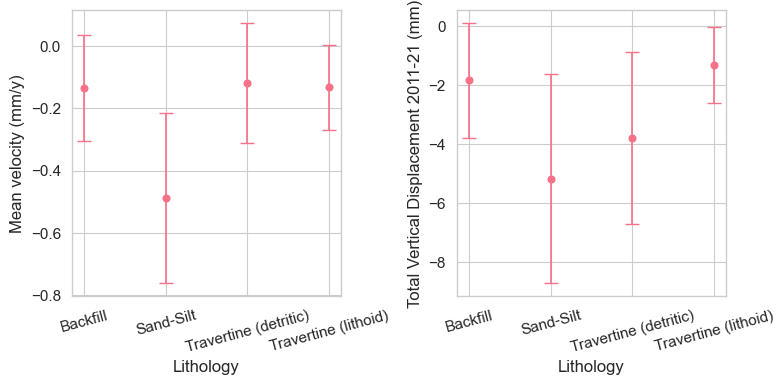

In [5]:
# Plot the scatter points with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.errorbar(velocity_stats['Lithology'], velocity_stats['median'], yerr=velocity_stats['std'], fmt='o', capsize=5)
ax2.errorbar(ud_disp_stats['Lithology'], ud_disp_stats['median'], yerr=ud_disp_stats['std'], fmt='o', capsize=5)

ax1.set_xlabel('Lithology')
ax1.set_ylabel('Mean velocity (mm/y)')
ax2.set_xlabel('Lithology')
ax2.set_ylabel('Total Vertical Displacement 2011-21 (mm)')

for tick in ax1.get_xticklabels():
    tick.set_rotation(15)
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()

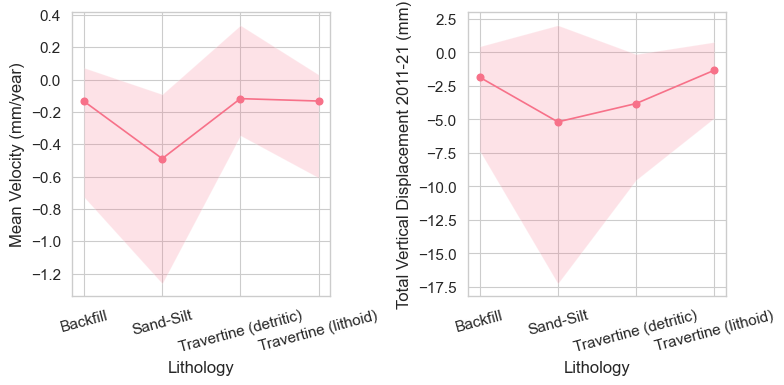

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(velocity_stats['Lithology'], velocity_stats['median'], 'o-')
ax1.fill_between(velocity_stats['Lithology'], velocity_stats['min'], velocity_stats['max'], alpha=0.2)

ax2.plot(ud_disp_stats['Lithology'], ud_disp_stats['median'], 'o-')
ax2.fill_between(ud_disp_stats['Lithology'], ud_disp_stats['min'], ud_disp_stats['max'], alpha=0.2)

ax1.set_xlabel('Lithology')
ax1.set_ylabel('Mean Velocity (mm/year)')
ax1.set_xticks(np.arange(len(velocity_stats['Lithology'])))
ax1.set_xticklabels(velocity_stats['Lithology'], rotation=15)

ax2.set_xlabel('Lithology')
ax2.set_ylabel('Total Vertical Displacement 2011-21 (mm)')
ax2.set_xticks(ud_disp_stats['Lithology'])
ax2.set_xticklabels(ud_disp_stats['Lithology'], rotation=15)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

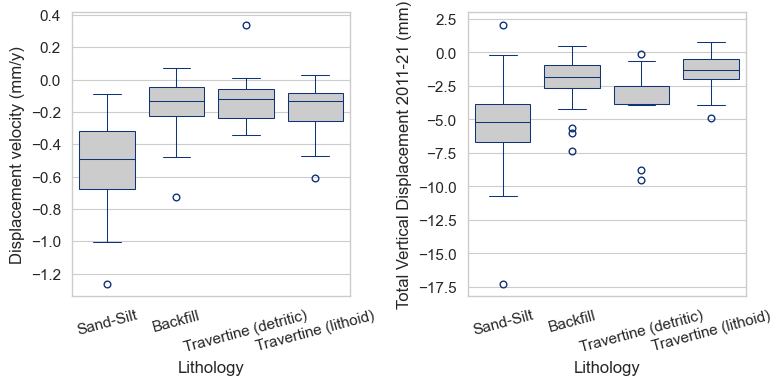

In [7]:
X = 'Lithology'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1 = sns.boxplot(data=data, x=X, y="VEL_ASC", color=".8", linecolor="#137", linewidth=.75, ax=ax1)
ax2 = sns.boxplot(data=data, x=X, y="UD_CUM", color=".8", linecolor="#137", linewidth=.75, ax=ax2)

ax1.set_xlabel("Lithology")
ax1.set_ylabel("Displacement velocity (mm/y)")
for tick in ax1.get_xticklabels():
    tick.set_rotation(15)
    
ax2.set_xlabel("Lithology")
ax2.set_ylabel("Total Vertical Displacement 2011-21 (mm)")
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

# Display the plot
plt.show()

## Cluster analysis

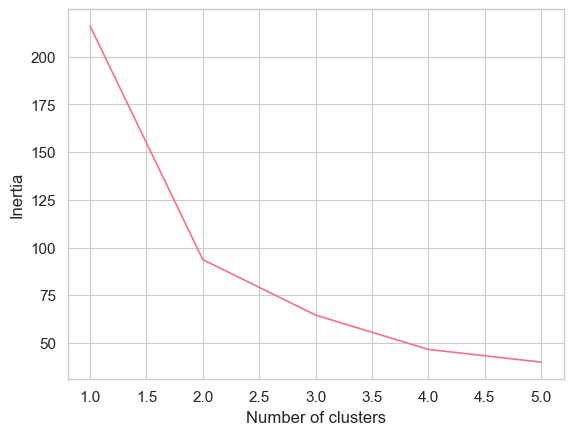

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the relevant features
features = data[['VEL_ASC', 'UD_CUM']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 6), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
# Based on the elbow plot, choose the optimal number of clusters (e.g., 2)
n_clusters = 2

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the original dataframe
data['Cluster'] = clusters

# Print the clusters
print(data.groupby('Cluster').agg({'VEL_ASC': 'mean', 'UD_CUM': 'mean', 'Lithology': 'nunique'}))

          VEL_ASC    UD_CUM  Lithology
Cluster                               
0       -0.553390 -6.457825          4
1       -0.143646 -1.567470          4


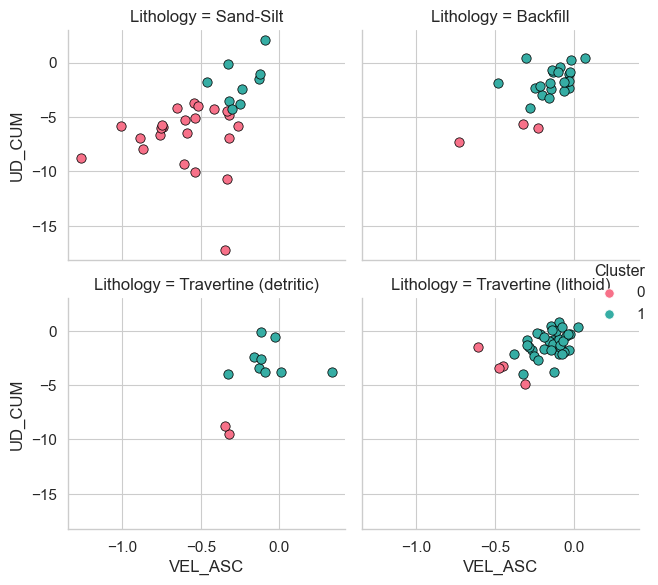

In [10]:
palette = sns.color_palette("husl", n_colors=len(data['Cluster'].unique()))

# Create scatterplot with columns based on 'Litologia' and colored by 'cluster'
g = sns.FacetGrid(data, col="Lithology", hue="Cluster", col_wrap=2, palette=palette, height=3, aspect=1)
g.map(sns.scatterplot, "VEL_ASC", "UD_CUM", marker="o", s=45)
g.add_legend(title="Cluster")

# Set marker edge color for all scatter points
for ax in g.axes.flat:
    for collection in ax.collections:
        if isinstance(collection, matplotlib.collections.PathCollection):
            collection.set_edgecolor("black")

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()

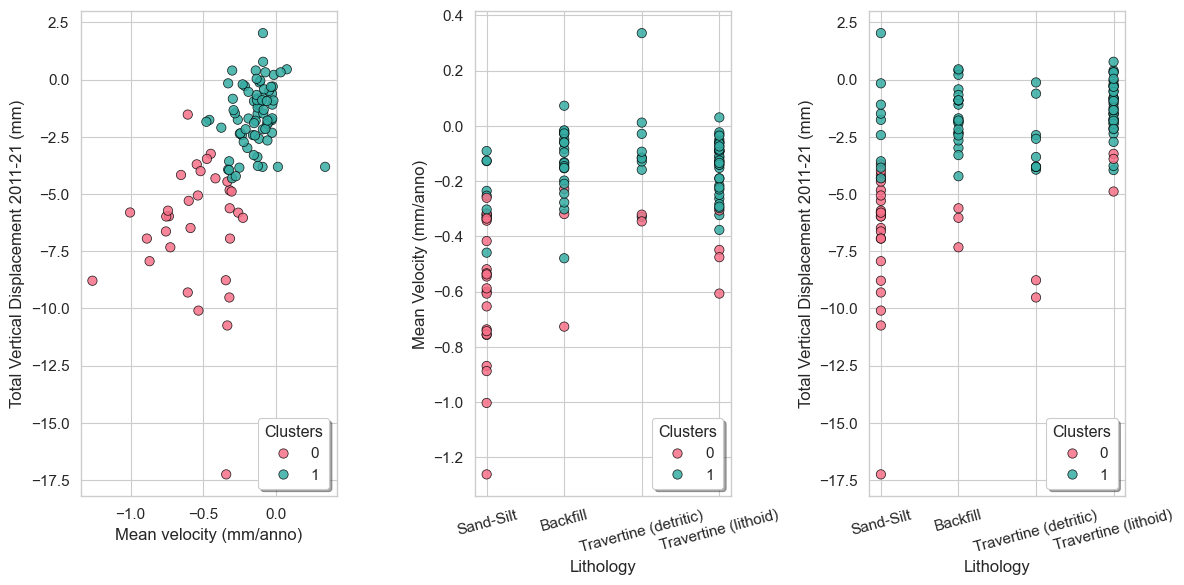

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))

# Plot VEL_ASC vs. UD_CUM colored by cluster
scatter1 = sns.scatterplot(x='VEL_ASC', y='UD_CUM', data=data, hue='Cluster', ax=ax1,
                           s=45, alpha=0.85, edgecolor='k', palette=palette)
# ax1.set_title('VEL_ASC vs. UD_CUM (Colored by Cluster)')
ax1.legend(bbox_to_anchor=(1, 0), loc='lower right', frameon=True, shadow=True, title='Clusters')  # Move the legend outside the plot
ax1.set_xlabel("Mean velocity (mm/anno)")
ax1.set_ylabel("Total Vertical Displacement 2011-21 (mm)")

# Plot VEL_ASC vs. COD_gt colored by cluster
scatter2 = sns.scatterplot(x='Lithology', y='VEL_ASC', data=data, hue='Cluster', ax=ax2,
                           s=45, alpha=0.85, edgecolor='k', palette=palette)

ax2.legend(bbox_to_anchor=(1, 0), loc='lower right', frameon=True, shadow=True, title='Clusters')  # Move the legend outside the plot
ax2.set_ylabel("Mean Velocity (mm/anno)")
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)

scatter3 = sns.scatterplot(x='Lithology', y='UD_CUM', data=data, hue='Cluster', ax=ax3,
                           s=45, alpha=0.85, edgecolor='k', palette=palette)

# ax3.set_title('UD_CUM vs. Litologia (Colored by Cluster)')
ax3.legend(bbox_to_anchor=(1, 0), loc='lower right', frameon=True, shadow=True, title='Clusters')  # Move the legend outside the plot
ax3.set_ylabel("Total Vertical Displacement 2011-21 (mm)")
for tick in ax3.get_xticklabels():
    tick.set_rotation(15)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
from sklearn.metrics import adjusted_rand_score

# Convert lithology to numeric labels
lithology_labels = data['Lithology'].apply(lambda x: 0 if x == 'Sand-Silt' else 1)

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(lithology_labels, clusters)
print(f'Adjusted Rand Index: {ari:.2f}')

Adjusted Rand Index: 0.42
